In [3]:
# Run parameter file to initialize packages, constants, functions, and timespacing
%run C:/Users/hohjo/Plasmonic_mixer/Lock_in_algo_war/Hoh_whitton_tretise_on_lockin/democratic_solution/Final_Params.ipynb

we good fam


In [4]:
###############################################################################################
#                                                                                             #
#                                        Lock-in Simulation (100 Mhz Tone)                    #
#                                                                                             #
###############################################################################################

#***********************************#
############################        #
# User Inputs:             #        #
#    Channel and Run time  #        #
############################        #
chan = 100                          #
run_time = 50                      #
#***********************************#
        
    # Define how many seconds of data should be simulated and how many accumulations are required

num_accum = int(run_time * (1/accum_time)) # number of total accumulations in simulation time

    # create file name for saving data in csv if desired

file_name = '%d_sec_lockin_sim_noiseless_gold.csv'%(run_time)    

    #Make an empty array to be filled with accumulations

lock_accums_i = np.zeros(num_accum)
lock_accums_q = np.zeros(num_accum)
lock_accums_mag = np.zeros(num_accum)

filt_accums_i = np.zeros(num_accum)
filt_accums_q = np.zeros(num_accum)

sig_max = 0

#***********************************#
#                                   #
#           Creating Time           #        
#                                   #
#***********************************#

for i in range(num_accum):
    print('we are on accumulation number %d out of %d'%(i+1, num_accum))

        ##### Create an array with the times of the FFT frames #####

    frame_times = np.linspace(i * frame_time, i * frame_time + (accum_frames-1) * frame_time, (accum_frames)  )

        ############################################################################################################    
        # Create an array of times that will be used to create the "pieces" of the wave                            #  
        # Populate time array with lengths to be used later                                                        #
        # This is an absolutely crazy vectorization of a previous loop I had, but it runs 100 times faster. Sorry. #
        ############################################################################################################

    timespace = np.linspace(np.linspace(frame_times[0], frame_times[1], FFT_length), 
                            np.linspace(frame_times[accum_frames-2], frame_times[accum_frames-1], FFT_length),
                            num = accum_frames-2)


#***********************************#
#                                   #
#            Signals                #
#   (Creation and Timestreaming)    #
#                                   #
#***********************************#

        # tone of interest
    signal = real_wave(1, source_freq, timespace)
       
        # Chop up signal at chop frequency (comment next line to get unchopped results)

    sq_wave = 0.5 * (sig.square(2 * np.pi * square_freq * timespace) + 1)
    choppa_signal = signal * sq_wave

        
        # Now put the choppeed noise signal through PFB

    spectra = (np.fft.fft(choppa_signal, n = FFT_length))*(2/FFT_length) 
        
        # Once again, take transpose of FFT matrix to get channel timestreams
    
    t_streams = np.transpose(spectra)
    t_streams_i = np.real(t_streams)
    t_streams_q = np.imag(t_streams)
    
    intensity = np.sqrt(np.square(t_streams_i) + np.square(t_streams_q))
   
    #plt.plot(intensity[100])
    #plt.title('timestream intensity')
    #plt.xlim(0,50)
    #plt.show()
    #print(np.sum(intensity[100])) 
    #########################################
    #    Mixing Channel Timestreams Down    #
    #########################################   

        # Create time array to control internally generated wave 

    timespace2 = np.linspace(i * frame_time, i * frame_time + (accum_frames-1) * frame_time, (accum_frames)-2)

        # Create generated signal inside FPGA at square wave frequency 

    chop_i, chop_q = cool_wave(1, square_freq, timespace2)
    sq_i = sq_trans(chop_i)
    sq_q = sq_trans(chop_q)
    #chop_i = 0.5 * (sig.square(2 * np.pi * square_freq * timespace2) + 1) 
    #chop_q = 0.5 * (sig.square(2 * np.pi * square_freq * timespace2 + (np.pi/2)) + 1)    
            
        # Mix together timestreams and chops
    
    downmix_i, downmix_q = c_mult(intensity[20], 0, sq_i, sq_q)
    #downmix_i, downmix_q = c_mult(t_streams_i[200], t_streams_q[200], chop_i, chop_q)

    downmix_mag = np.square(downmix_i) + np.square(downmix_q)
    
    ##### MAKING A CHEEKY INTEGRATOR #####

    N  = 7    # Filter order
    Wn = .02 # Cutoff frequency
    B, A = sig.butter(N, Wn, output='ba')
    filt_mix_i = sig.filtfilt(B,A,downmix_i)
    filt_mix_q = sig.filtfilt(B,A,downmix_q)

        # Now integrate the timestream as is done in firmware
        # Create two different sets of data to compare filtered and unfiltered mixing output
        
    filt_sq_i = np.square(filt_mix_i)
    filt_sq_q = np.square(filt_mix_q)
    filt_mag = filt_sq_i + filt_sq_q
    
    
    #accum_i = np.sum(downmix_i)
    #accum_q = np.sum(downmix_q)
    #mag_accum = np.sum(downmix_mag)

    filt_accum_i = np.sum(filt_mix_i)
    filt_accum_q = np.sum(filt_mix_q)
    mag_accum = np.sum(filt_mag)
    #print(accum)

        # Plop the accumulation data into our accumulation array for further faffing about
        # Have an array for low pass filtered and unfiltered data
    
    #lock_accums_i[i] = accum_i
    #lock_accums_q[i] = accum_q
    lock_accums_mag[i] = mag_accum
    
    filt_accums_i[i] = filt_accum_i
    filt_accums_q[i] = filt_accum_q

# save data for when computer crashes

save_data('%d_sec_noiseless_lockin_sim_gold_mag.csv'%(run_time), lock_accums_mag)
save_data('%d_sec_noiseless_lockin_sim_gold_i.csv'%(run_time), lock_accums_i)
save_data('%d_sec_noiseless_lockin_sim_gold_q.csv'%(run_time), lock_accums_q)



#print(np.average(lock_accums))

we are on accumulation number 1 out of 838


C:\Users\hohjo\Anaconda3\lib\site-packages\ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in true_divide


we are on accumulation number 2 out of 838
we are on accumulation number 3 out of 838
we are on accumulation number 4 out of 838
we are on accumulation number 5 out of 838
we are on accumulation number 6 out of 838
we are on accumulation number 7 out of 838
we are on accumulation number 8 out of 838
we are on accumulation number 9 out of 838
we are on accumulation number 10 out of 838
we are on accumulation number 11 out of 838
we are on accumulation number 12 out of 838
we are on accumulation number 13 out of 838
we are on accumulation number 14 out of 838
we are on accumulation number 15 out of 838
we are on accumulation number 16 out of 838
we are on accumulation number 17 out of 838
we are on accumulation number 18 out of 838
we are on accumulation number 19 out of 838
we are on accumulation number 20 out of 838
we are on accumulation number 21 out of 838
we are on accumulation number 22 out of 838
we are on accumulation number 23 out of 838
we are on accumulation number 24 out of 

we are on accumulation number 187 out of 838
we are on accumulation number 188 out of 838
we are on accumulation number 189 out of 838
we are on accumulation number 190 out of 838
we are on accumulation number 191 out of 838
we are on accumulation number 192 out of 838
we are on accumulation number 193 out of 838
we are on accumulation number 194 out of 838
we are on accumulation number 195 out of 838
we are on accumulation number 196 out of 838
we are on accumulation number 197 out of 838
we are on accumulation number 198 out of 838
we are on accumulation number 199 out of 838
we are on accumulation number 200 out of 838
we are on accumulation number 201 out of 838
we are on accumulation number 202 out of 838
we are on accumulation number 203 out of 838
we are on accumulation number 204 out of 838
we are on accumulation number 205 out of 838
we are on accumulation number 206 out of 838
we are on accumulation number 207 out of 838
we are on accumulation number 208 out of 838
we are on 

we are on accumulation number 370 out of 838
we are on accumulation number 371 out of 838
we are on accumulation number 372 out of 838
we are on accumulation number 373 out of 838
we are on accumulation number 374 out of 838
we are on accumulation number 375 out of 838
we are on accumulation number 376 out of 838
we are on accumulation number 377 out of 838
we are on accumulation number 378 out of 838
we are on accumulation number 379 out of 838
we are on accumulation number 380 out of 838
we are on accumulation number 381 out of 838
we are on accumulation number 382 out of 838
we are on accumulation number 383 out of 838
we are on accumulation number 384 out of 838
we are on accumulation number 385 out of 838
we are on accumulation number 386 out of 838
we are on accumulation number 387 out of 838
we are on accumulation number 388 out of 838
we are on accumulation number 389 out of 838
we are on accumulation number 390 out of 838
we are on accumulation number 391 out of 838
we are on 

we are on accumulation number 553 out of 838
we are on accumulation number 554 out of 838
we are on accumulation number 555 out of 838
we are on accumulation number 556 out of 838
we are on accumulation number 557 out of 838
we are on accumulation number 558 out of 838
we are on accumulation number 559 out of 838
we are on accumulation number 560 out of 838
we are on accumulation number 561 out of 838
we are on accumulation number 562 out of 838
we are on accumulation number 563 out of 838
we are on accumulation number 564 out of 838
we are on accumulation number 565 out of 838
we are on accumulation number 566 out of 838
we are on accumulation number 567 out of 838
we are on accumulation number 568 out of 838
we are on accumulation number 569 out of 838
we are on accumulation number 570 out of 838
we are on accumulation number 571 out of 838
we are on accumulation number 572 out of 838
we are on accumulation number 573 out of 838
we are on accumulation number 574 out of 838
we are on 

we are on accumulation number 736 out of 838
we are on accumulation number 737 out of 838
we are on accumulation number 738 out of 838
we are on accumulation number 739 out of 838
we are on accumulation number 740 out of 838
we are on accumulation number 741 out of 838
we are on accumulation number 742 out of 838
we are on accumulation number 743 out of 838
we are on accumulation number 744 out of 838
we are on accumulation number 745 out of 838
we are on accumulation number 746 out of 838
we are on accumulation number 747 out of 838
we are on accumulation number 748 out of 838
we are on accumulation number 749 out of 838
we are on accumulation number 750 out of 838
we are on accumulation number 751 out of 838
we are on accumulation number 752 out of 838
we are on accumulation number 753 out of 838
we are on accumulation number 754 out of 838
we are on accumulation number 755 out of 838
we are on accumulation number 756 out of 838
we are on accumulation number 757 out of 838
we are on 

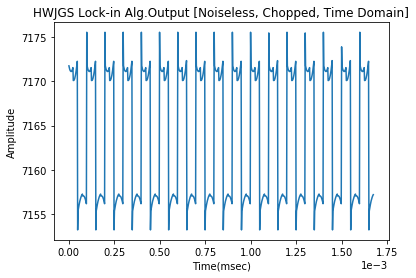

In [14]:
plt.plot(samp_2_sec_2(np.arange(0,len(lock_accums_mag))),lock_accums_mag)
#plt.xlim(0,1*10**-6)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.xlabel('Time(msec)')
#plt.xlabel('Time($\mu$s)')
plt.ylabel('Amplitude')
plt.title('HWJGS Lock-in Alg.Output [Noiseless, Chopped, Time Domain]')
plt.show()

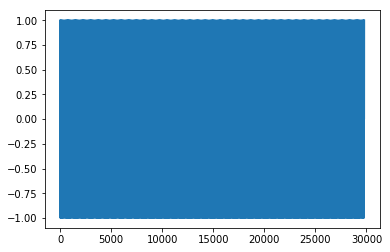

In [18]:
plt.plot(downmix_i)

In [36]:
N  = 7    # Filter order
Wn = .02 # Cutoff frequency
B, A = sig.butter(N, Wn, output='ba')
filt_mix_i = sig.filtfilt(B,A,downmix_i)
filt_mix_q = sig.filtfilt(B,A,downmix_q)


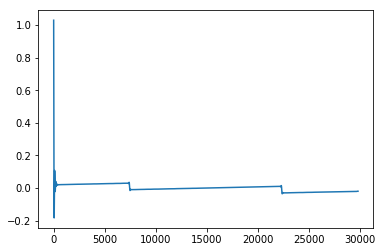

In [37]:
plt.plot(filt_mix_i)

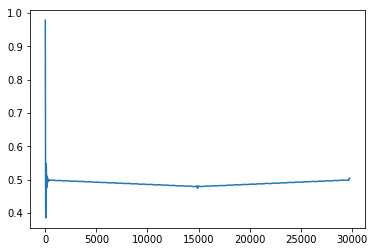

In [38]:
plt.plot(filt_mix_q)

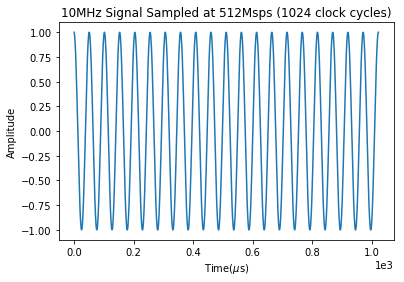

In [32]:
#plt.plot(samp_2_sec(np.arange(0,1024)), signal[0])
plt.plot(signal[5])
#plt.xlim(0,1*10**-6)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.xlabel('Time($\mu$s)')
plt.ylabel('Amplitude')
plt.title('10MHz Signal Sampled at 512Msps (1024 clock cycles)')
plt.show()

In [7]:
flat_sig = signal.flatten()
flat_sq = sq_wave.flatten()
flat_chop = choppa_signal.flatten()
vec_len = np.shape(flat_sq)[0]
vec_len_2 = vec_len/1024

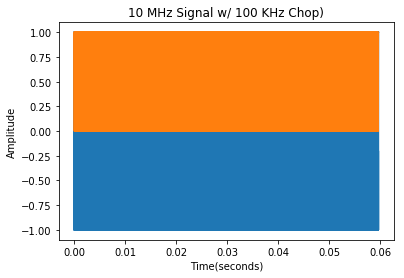

In [8]:
plt.plot(samp_2_sec(np.arange(0,vec_len)), flat_sig)
plt.plot(samp_2_sec(np.arange(0,vec_len)), flat_sq)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.xlim(0,1/(25*10**3))
plt.xlabel('Time(seconds)')
plt.ylabel('Amplitude')
plt.title('10 MHz Signal w/ 100 KHz Chop)')
plt.show()

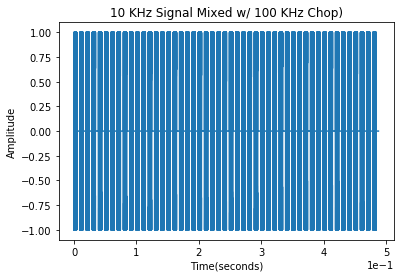

In [78]:
plt.plot(samp_2_sec(np.arange(0,vec_len)), flat_chop)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
#plt.xlim(0,1/(25*10**3))
plt.xlabel('Time(seconds)')
plt.ylabel('Amplitude')
plt.title('10 KHz Signal Mixed w/ 100 KHz Chop)')
plt.show()

Text(0, 0.5, 'Intensity')

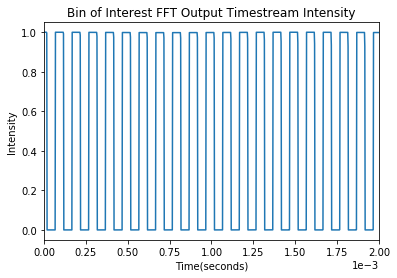

In [14]:
plt.plot(samp_2_sec_2(np.arange(0,vec_len_2)),intensity[20])
plt.xlim(0,50000/(25*10**6))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title('Bin of Interest FFT Output Timestream Intensity' )
plt.xlabel('Time(seconds)')
plt.ylabel('Intensity')

Text(0, 0.5, 'Amplitude')

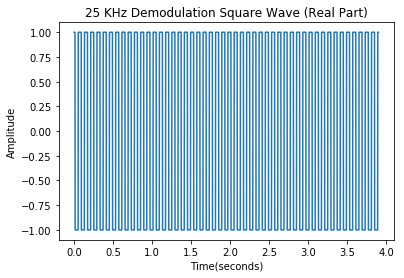

In [81]:
plt.plot(samp_2_sec_2(np.arange(0,vec_len_2)),sq_i)
#plt.xlim(0,40/(25*10**3))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title('25 KHz Demodulation Square Wave (Real Part)' )
plt.xlabel('Time(seconds)')
plt.ylabel('Amplitude')

Text(0, 0.5, 'Amplitude')

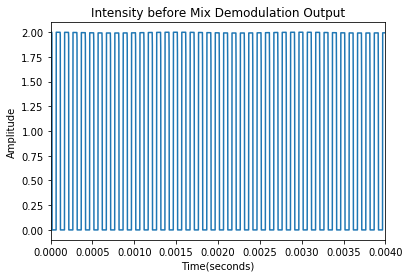

In [17]:
plt.plot(samp_2_sec_2(np.arange(0,29800)),downmix_mag)
plt.xlim(0,40/(10*10**3))
#plt.ylim(0,3)
plt.title('Intensity before Mix Demodulation Output' )
plt.xlabel('Time(seconds)')
plt.ylabel('Amplitude')

Text(0, 0.5, 'Amplitude')

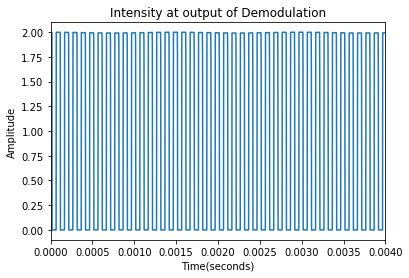

In [3]:
plt.plot(samp_2_sec_2(np.arange(0,29800)),downmix_mag)
plt.xlim(0,40/(10*10**3))
#plt.ylim(0,3)
plt.title('Intensity at output of Demodulation' )
plt.xlabel('Time(seconds)')
plt.ylabel('Amplitude')

4815825.167891413

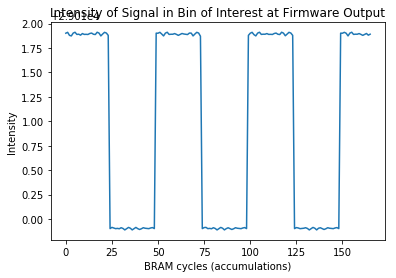

In [4]:
plt.plot(lock_accums_mag[1::])
plt.title('Intensity of Signal in Bin of Interest at Firmware Output' )
plt.xlabel('BRAM cycles (accumulations)')
plt.ylabel('Intensity')
np.sum(lock_accums_mag[1::])